# Convolutional Neural Networks

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 19/02/2025  | Martin | Created   | Continuing chapters for CNN | 
| 26/02/2025  | Martin | Updated   | Completed StyleNet, working on DeepDream | 

# Content

* [Applying StyleNet and Neural Style Project](#applying-stylenet-and-neural-style-project)
* [Implementing DeepDream](#implementing-deepdream)

# Applying StyleNet and Neural Style Project

## StyleNet

* A procedure that attempts to learn an image style from one picture and apply it to a second picture, while keeping the second image structure in tact
* Find intermediate CNN nodes that correlate strongly with the "style" and separate it from the contents of the image
* Based on a 2015 paper by Leon Gatys
* Train the style layers on the first picture and contents on the second

In [13]:
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display
from tensorflow import keras
import PIL.Image

In [14]:
# Images files
path = './images/'
content_image_file = path + "book_cover.jpg"
style_image_file = path + "starry_night.jpg"

# Read and convert images
content_image = imageio.imread(content_image_file)
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = imageio.imread(style_image_file)
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

# Get shape of target and make the style image the same
target_shape = content_image.shape
style_image = tf.image.resize(style_image, target_shape[:2])

C:\Users\User\AppData\Local\Temp\ipykernel_22420\1938049986.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  content_image = imageio.imread(content_image_file)
C:\Users\User\AppData\Local\Temp\ipykernel_22420\1938049986.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  style_image = imageio.imread(style_image_file)


Text(0.5, 1.0, 'Style Image')

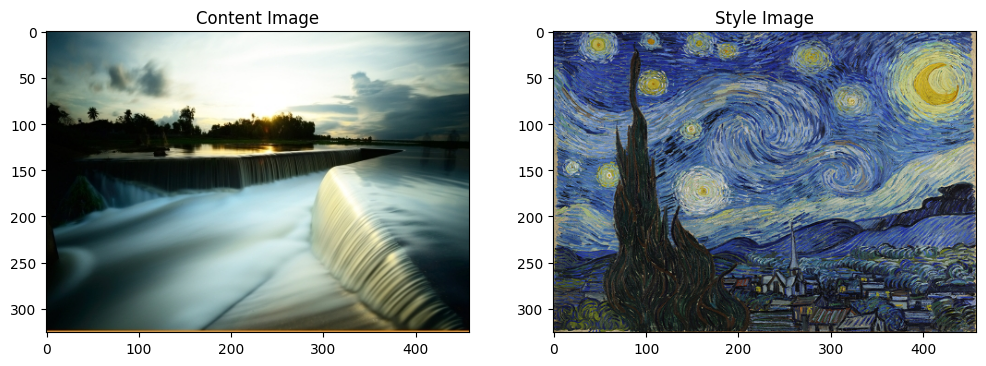

In [15]:
# Disoplay the images
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("Style Image")

In [16]:
# Define VGG model
vgg = tf.keras.applications.VGG19(
  include_top=False,
  weights='imagenet'
)
vgg.trainable = False

# print the architecture
[layer.name for layer in vgg.layers]

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

_Neural style transfer:_ Apply the style of one image to the contents of another image

The paper recommended different strategies for assigning intermediate layers to the content and style images. Keep block4_conv2 for content image, can use different combinations of other convolution layer outputs for the style image

In [17]:
content_layers = ['block4_conv2', 'block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Values of the intermediate feature maps represent the content of an image, the style can be descirbed by the means adn correlations across the feature maps

_Gram Matrix:_ Measures the degree of correlation between each of the feature maps

The _Gram Matrix_ captures the style of an image. The computation is done on each intermediate feature maps and get only information about the texture of an image. We lose information about its spatial structure.

In [18]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result / (num_locations)

Model returns style and content dictionaries which contain the name of each layer and associated content/ style tensors. The Gram Matrix is applied on all the style layers

In [19]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    self.vgg = tf.keras.Model([vgg.input], outputs)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  def call(self, inputs):
    inputs = inputs * 255.0 # Expect float inputs in range [0, 1]
    inputs = inputs[tf.newaxis, :] # newaxis extends the dimensions of the tensor
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (
      outputs[:self.num_style_layers],
      outputs[self.num_style_layers:]
    )

    style_output = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {
      'content': content_dict,
      'style': style_dict
    }

In [20]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

d:\Software\venv\py311_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 326, 458, 3))
  warnings.warn(msg)


In [21]:
# Optimiser configurations
learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999

opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)

# Loss will be computed as a weighted sum of the content and style loss
content_weight = 50.0
style_weight = 10.0

__Defining the Loss__

Loss function is defined as the combined (sum) loss of:

1. Style feature loss: Loss between the style feature of the style picture and current image
2. Content image loss: Loss between the contents of the original image and current image
3. Total variation loss: Penalises sharp change and promotes smoothness int the image

In [22]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

In [23]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

....................................................................................................

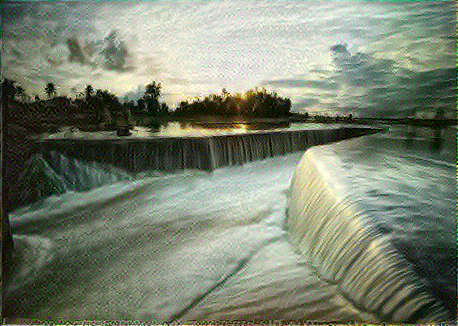

In [24]:
generations = 100

image = tf.Variable(content_image)

for generation in range(generations):

  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([( grad, image )])
  image.assign(clip_0_1(image))

  print(".", end='')

display.display(tensor_to_image(image))

## Model Review

* The style and content emphasis can be changed by changing the respective weights

---

# Implementing DeepDream

_DeepDream:_ Over-interpret the patterns that the model detects and generate inspiring content with surreal patterns

CNNs create nodes that detect features of labels. Use these nodes to transform any image to reflect those node features more prominently

In [25]:
import numpy as np
import PIL.Image
import imageio
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf

import IPython.display as display

C:\Users\User\AppData\Local\Temp\ipykernel_22420\1887427566.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_img = imageio.imread('images/book_cover.jpg')


Text(0.5, 1.0, 'Original Image')

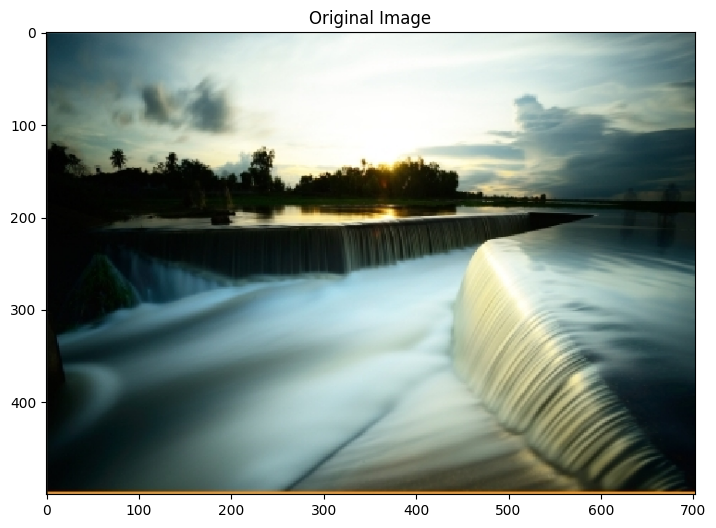

In [28]:
original_img = imageio.imread('images/book_cover.jpg')

# Reshape image to 500 max dim
new_shape = tf.cast(
  (500, 500 * original_img.shape[1] / original_img.shape[0]),
  tf.int32
)
original_img = tf.image.resize(original_img, new_shape, method='nearest').numpy()

# Display the image
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['axes.grid'] = False

plt.imshow(original_img)
plt.title("Original Image")

In [29]:
# Load inception model
inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

inception.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In a CNN, earlier layers detect features like edges, shapes and textures; later layers detect higher-level features like objects and backgrounds

For DeepDream, we focus on layers where convolutions are mixed. We create the feature extraction model with 2 mixed layers as outputs

In [ ]:
# Select the layers that we want to extract
names = ['mixed3', 'mixed5']
layers = [inception.get_layer(name).output for name in names]
deep_dream_model = tf.keras.Model(inputs=inception.input, outputs=layers)

In [31]:
# Loss function - sum of all output layers
def compute_loss(img, model):
  # Add a dimension to the image to have a batch size 1.
  img_batch = tf.expand_dims(img, axis=0)

  # Apply the model to the image and get the outputs to retrieve the activation
  layer_activations = model(img_batch)

  # Compute loss for each layer
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)